# EDA 003 - Voxelmorph - Single slice analysis

As we are now sure on how to use the coordinate system between all frameworks -numpy&sitk- we can now continue our journey by training a voxelmorph model that predicts the motion on a single slice, to see where the errors are and if we can actually mitigate them, by doing tissue tracking and feature tracking. Also, a model with big displacements (from end-diastole to end-systole) will be trained to also measure errors on a large displacement case. We will then compare with the [database]() ground-truth, and the method we used before, [fast symmetric forces demons]().

## Objectives 📋

This notebook aims to:
- Measure the methodology error, by getting:
  - Boxplot of total errors
  - Graphical flow-norm analysis
  - Graphical quiver analysis
  - Graphical difference analysis
- Understand if we're able to make better predictions by modifying cerain parameters of the training or preprocessing stages.

## Imports ⚙️

In [1]:
import numpy as np
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "5"  # so TF shuts the f up
import SimpleITK as sitk
from tvtk.api import tvtk
import matplotlib.pyplot as plt
import tensorflow as tf
import voxelmorph as vxm
import cv2
from natsort import natsorted
from itertools import cycle

## Data loading & preprocessing 📈

We will have two different preprocessing flavors: tissue tracking and feature tracking, both found in `preprocess`:

- In Tissue Tracking the preprocessing is normalizing each image, matching the $F \to M$ histograms, and resizing them to the `input_shape` of the network. 
- Additional to that, in Feature Tracking we also detect the borders before matching the histograms or resizing.

As for the loading process -in `load_data`-, the input of the vxm network is a $(F, M)$ pair (of course!) and we need a $(M, \Phi)$ as the training output, where $\Phi$ is a zero-filled transform with the adequate $(\text{height}, \text{width}, 2)$ size.

Finally, `get_straus_dataset` is a function that gets the adequate filenames of each study, randomizes their names, and loads them through a generator using `load_data`. We will use the first 9 patients (`v1` to `v10`) to train.

Function implementation for all tasks can be seen in the appendix.

In [2]:
from helpers import get_straus_dataset, get_ed_es_dataset

in_cluster = False
folder = (
    "/share/apps/DeepLearning/Datos/MRI/Straus/SyntheticMRI/"
    if in_cluster
    else (
        "/mnt/d/Balseiro/Tesis-MFM/OtrosDatos/"
        + "www-sop.inria.fr/asclepios/data/STRAUS/SyntheticMRI"
    )
)
out_shape = (64, 64)
slices = [5]
batch_size = 32

train_data_tissue_tracking = get_straus_dataset(folder, out_shape, batch_size, False)
train_data_feature_tracking = get_straus_dataset(folder, out_shape, batch_size, True)

train_ed_es_tissue_tracking = get_ed_es_dataset(folder, out_shape, batch_size, False)
train_ed_es_feature_tracking = get_ed_es_dataset(folder, out_shape, batch_size, True)


## Model definition and training 🏋️

We're going to use the VxmDense model from [Voxelmorph](https://github.com/voxelmorph/voxelmorph). Bear in mind there are several parameters on it's constructor API, that can be seen on the [source code](https://github.com/voxelmorph/voxelmorph/blob/98d4f368e71683bcb0ee0de9203480153ed1aa9c/voxelmorph/tf/networks.py#L48) (he already has docstrings, why not pull up a small sphinx page?). 

Among the most important ones for our study case are the Diffeomorphism API options. Those are:

- int_steps: Number of flow integration steps. The warp is non-diffeomorphic when this value is 0.
- svf_resolution: Resolution (relative voxel size) of the predicted SVF. Default is 1.
- int_resolution: Resolution (relative voxel size) of the flow field during vector integration. Default is 2.
- reg_field: Field to regularize in the loss. Options are:
  - 'svf' to return the SVF predicted by the Unet,
  - 'preintegrated' to return the SVF that's been rescaled for vector-integration (default),
  - 'postintegrated' to return the rescaled vector-integrated field, 
  - and 'warp' to return the final, full-res warp.

Nonetheless, it seems that the API code is more up-to-date than the latest release (0.1 in PyPI), so we will just use `int_steps` and `int_downsize`.

We can also control the output shape and the Unet features.

We will train diffeomorphic and non-diffeomorphic versions of all models. 

Thus, we have three control variables in this study:
- Feature Tracking vs Tissue Tracking
- ED-ES vs full sequence
- Regular vs Diffeomorphic field
which gives us 8 total models to train.

These models will be trained in the DFM cluster.

In [3]:
from helpers import regular_model, diffeomorphic_model, train

nb_features = [
    [32, 32, 32, 32],         # encoder features
    [32, 32, 32, 32, 32, 16]  # decoder features
]
reg_strength = 0.01
l_rate = 1e-3
epochs = 30
steps_full = 250
steps_ed_es = 16
already_trained_models = True

if already_trained_models:
    tt_comm = vxm.networks.VxmDense.load(f"models/tt_comm.h5")
    ft_comm = vxm.networks.VxmDense.load(f"models/ft_comm.h5")
    tt_diff = vxm.networks.VxmDense.load(f"models/tt_diff.h5")
    ft_diff = vxm.networks.VxmDense.load(f"models/ft_diff.h5")
    tt_comm_ed_es = vxm.networks.VxmDense.load(f"models/tt_comm_ed_es.h5")
    ft_comm_ed_es = vxm.networks.VxmDense.load(f"models/ft_comm_ed_es.h5")
    tt_diff_ed_es = vxm.networks.VxmDense.load(f"models/tt_diff_ed_es.h5")
    ft_diff_ed_es = vxm.networks.VxmDense.load(f"models/ft_diff_ed_es.h5")
else: 
    tt_comm = regular_model(nb_features, out_shape, l_rate, reg_strength)
    train(tt_comm, train_data_tissue_tracking, epochs, steps_full, "tt_comm")

    ft_comm = regular_model(nb_features, out_shape, l_rate, reg_strength)
    train(ft_comm, train_data_feature_tracking, epochs, steps_full, "ft_comm")

    tt_diff = diffeomorphic_model(nb_features, out_shape, l_rate, reg_strength)
    train(tt_diff, train_data_tissue_tracking, epochs, steps_full, "tt_diff")

    ft_diff = diffeomorphic_model(nb_features, out_shape, l_rate, reg_strength)
    train(ft_diff, train_data_feature_tracking, epochs, steps_full, "ft_diff")

    tt_comm_ed_es = regular_model(nb_features, out_shape, l_rate, reg_strength)
    train(tt_comm, train_ed_es_tissue_tracking, epochs, steps_ed_es, "tt_comm_ed_es")

    ft_comm_ed_es = regular_model(nb_features, out_shape, l_rate, reg_strength)
    train(ft_comm, train_ed_es_feature_tracking, epochs, steps_ed_es, "ft_comm_ed_es")

    tt_diff_ed_es = diffeomorphic_model(nb_features, out_shape, l_rate, reg_strength)
    train(tt_diff, train_ed_es_tissue_tracking, epochs, steps_ed_es, "tt_diff_ed_es")

    ft_diff_ed_es = diffeomorphic_model(nb_features, out_shape, l_rate, reg_strength)
    train(ft_diff, train_ed_es_feature_tracking, epochs, steps_ed_es, "ft_diff_ed_es")


Instructions for updating:
Use fn_output_signature instead


## Analysis 👨‍🔬

Now that we have our trained models, we will make several comparisons between the displacement fields of the techniques we used, the ground truth and Demons. 




### End dyastole to end systole

The first analysis I'm going to focus is in correctly getting the displacement fields and moved images for:
- Ground truth (only F and M images)
- Voxelmorph - non-diffeomorphic
- Diffeomorphic Demons

I'm first making a visual comparison (prepare, big image incoming!) between the methods to see what the displacement field looks like. Then, I'm going to measure the error we're making on the image. Afterwards, I will check the difference between proposed methodologies. Lastly, I will measure the errors against the ground truth.

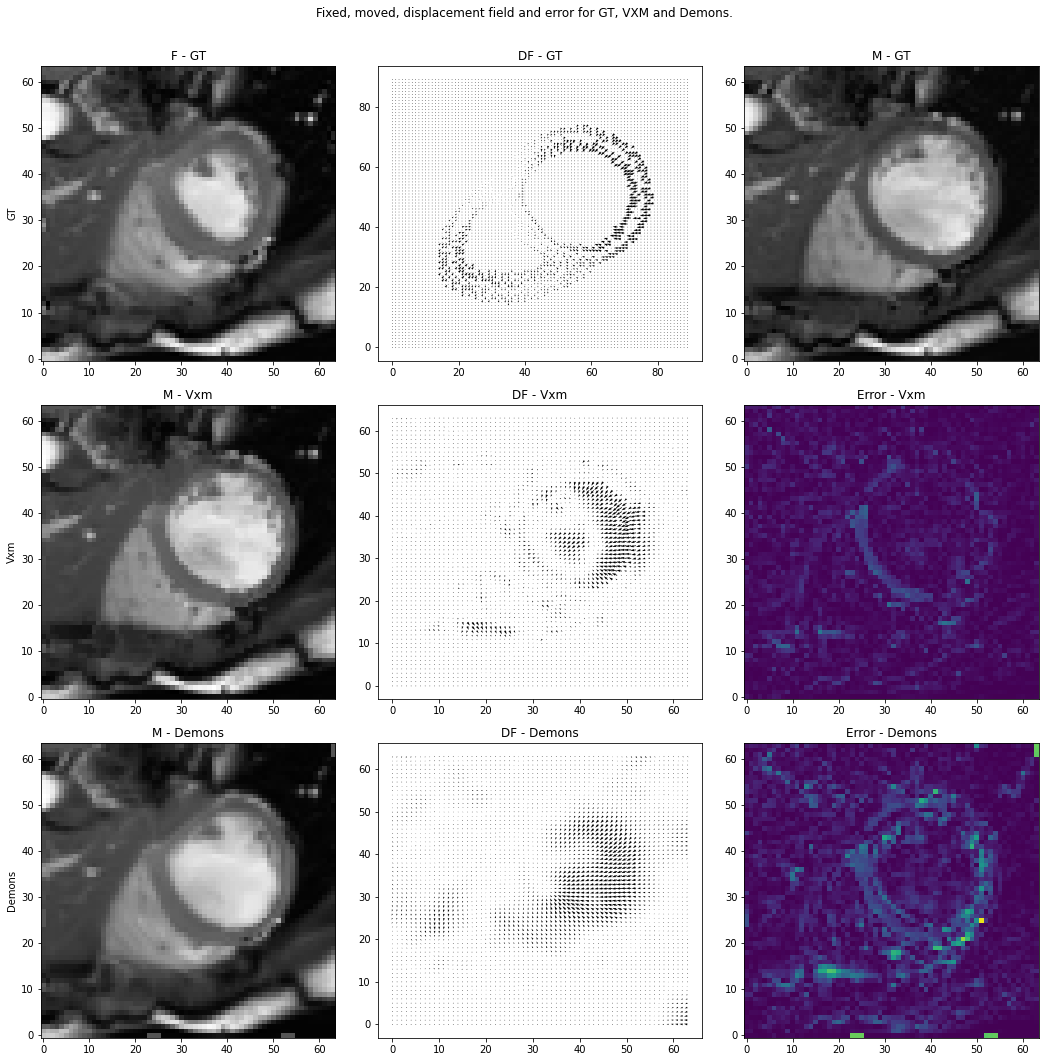

In [31]:
# Get a pair of ED-ES images, complete tissue and borders
from helpers import get_ed_es_images, get_ed_es_diff_gt
(F, M), _ = get_ed_es_images(folder, "v4", out_shape, False)
Phi_gt_ = get_ed_es_diff_gt(folder, "v4", out_shape)
Phi_gt = Phi_gt_
Phi_gt[0, ...] = Phi_gt_[1, ...]
Phi_gt[1, ...] = Phi_gt_[0, ...]
# Predict the moved image and displacement field
Mv, Phi = tt_comm_ed_es.predict((F, M))
Mv_d, Phi_d = tt_diff_ed_es.predict((F, M))
Mv_, Mv_d_= Mv[0, ..., 0], Mv_d[0, ..., 0]


# Get Demons displacement field
F_, M_ = F[0, ..., 0], M[0, ..., 0]
F_sitk, M_sitk  = sitk.GetImageFromArray(F_), sitk.GetImageFromArray(M_)
demons_filter = sitk.FastSymmetricForcesDemonsRegistrationFilter()
demons_filter.SetNumberOfIterations(500)
Phi_sitk = demons_filter.Execute(M_sitk, F_sitk)
resampler = sitk.ResampleImageFilter()
resampler.SetReferenceImage(F_sitk)
tf = sitk.DisplacementFieldTransform(sitk.Cast(Phi_sitk, sitk.sitkVectorFloat64))
resampler.SetTransform(tf)
Mv_sitk = resampler.Execute(F_sitk)
Mv_demons = sitk.GetArrayFromImage(Mv_sitk)
Phi_demons = sitk.GetArrayFromImage(Phi_sitk)

# Plot
Phigt_x, Phigt_y = Phi_gt[..., 5, 0], Phi_gt[..., 5 , 1]
Phix, Phiy = Phi[0, ..., 1], Phi[0, ..., 0]
Phix_d, Phiy_d = Phi_d[0, ..., 1], Phi_d[0, ..., 0]
Phix_dem, Phiy_dem = Phi_demons[... , 0], Phi_demons[..., 1]
fig, axs = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle("Fixed, moved, displacement field and error for GT, VXM and Demons.\n\n")
axs[0, 0].imshow(F_, cmap="gray", origin="lower"), axs[0,0].set_ylabel("GT")
axs[0, 1].quiver(Phigt_x, Phigt_y, angles='xy', scale_units='xy', scale=5)
axs[0, 2].imshow(M_, cmap="gray", origin="lower")
axs[1, 0].imshow(Mv_, cmap="gray", origin="lower"), axs[1,0].set_ylabel("Vxm")
axs[1, 1].quiver(Phix, Phiy, angles='xy', scale_units='xy', scale=5)
axs[1, 2].imshow(np.abs(Mv_ - M_), origin="lower", vmin=0, vmax=1.5)
axs[2, 0].imshow(Mv_demons, cmap="gray", origin="lower"), axs[2,0].set_ylabel("Demons")
axs[2, 1].quiver(Phix_dem, Phiy_dem,  angles='xy', scale_units='xy', scale=5)
axs[2, 2].imshow(np.abs(Mv_demons - M_), origin="lower", vmin=0, vmax=1.5)
axs[0,0].set_title("F - GT"),axs[0,1].set_title("DF - GT"),axs[0,2].set_title("M - GT")
for row, method in enumerate(["Vxm", "Demons"]):
    for col, image in enumerate(["M", "DF", "Error"]):
        axs[row+1, col].set_title(f"{image} - {method}") 
plt.tight_layout()
plt.show()

What this image is showing us is:
- The Voxelmorph methods seem to correctly get the moved image, doing a significantly better job than demons.
- The displacement field they predict is WAY less regular than the one Demons predicts.

From the looks of it, it seems we may have a regularization issue. Yes, the predicted images are better (error is smaller in most points) and the field does look a lot more like the ground truth. And that is really, really nice. Now, why were we getting so much error? Well, it might seem the upsample/downsample might be making some noise. A BIG issue in our methodology is the difference between the dimensions of the original image and the interpolated image.

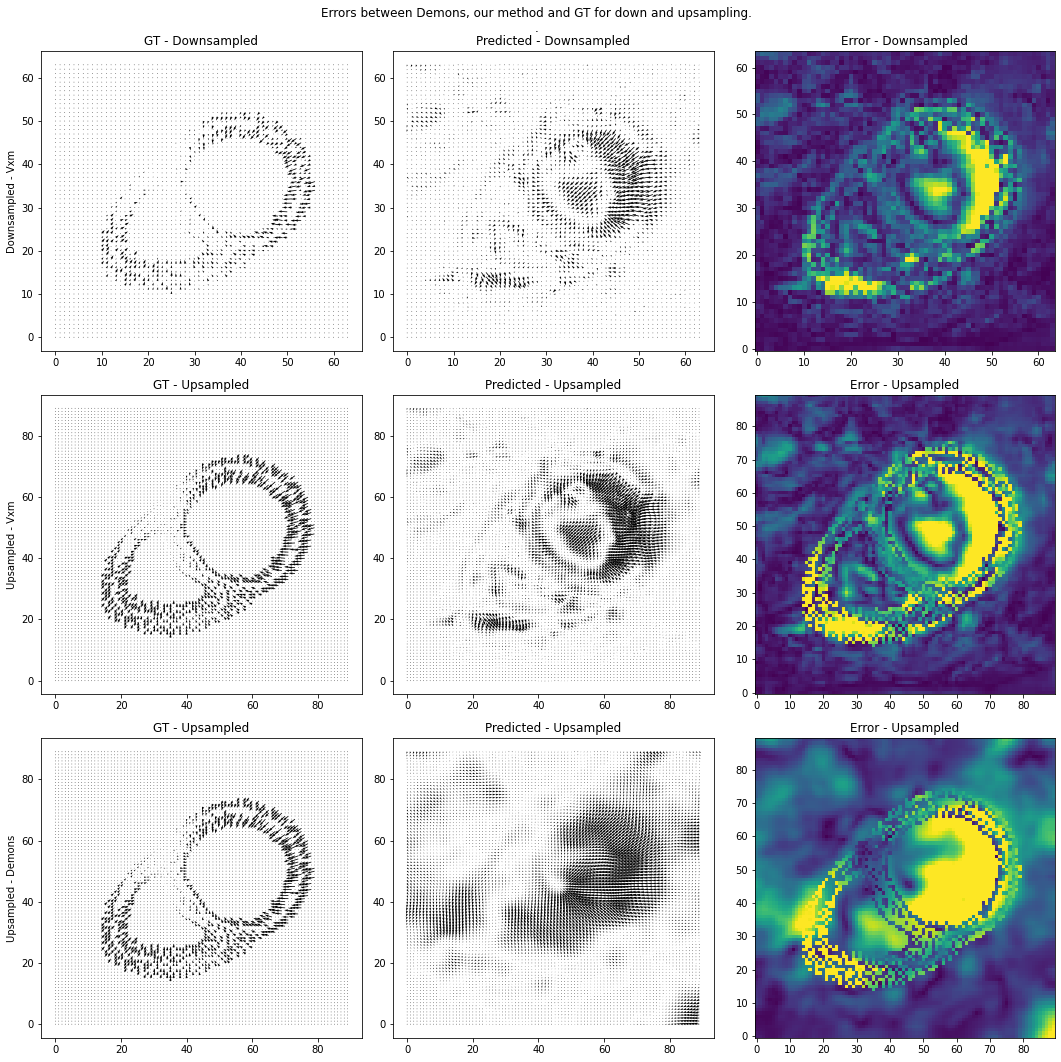

In [40]:
# Predict the moved image and displacement field
shape = (Phi_gt.shape[0], Phi_gt.shape[1])
Phi_ = np.zeros_like(Phi)
Phi_demons_ = np.zeros_like(Phi_demons)
Phi_[0, ..., 1] = Phi[0, ..., 0]
Phi_[0, ..., 0] = Phi[0, ..., 1]
Phi_demons_[..., 1] = Phi_demons[..., 0]
Phi_demons_[..., 0] = Phi_demons[..., 1]
Phi_usz = cv2.resize(Phi_[0], shape) * shape[0]/out_shape[0]
Phi_demons_usz = cv2.resize(Phi_demons_, shape) * shape[0]/out_shape[0]
Phi_gt_dsz = cv2.resize(Phi_gt[..., 5, :-1], out_shape) * out_shape[0]/shape[0]

Phi_demons_usz_ = np.zeros_like(Phi_demons_usz)
Phi_demons_usz_[..., 0] = Phi_demons_usz[..., 1]
Phi_demons_usz_[..., 1] = Phi_demons_usz[..., 0]

error_lsz = np.linalg.norm(Phi_[0] - Phi_gt_dsz, axis=2)
error_hsz = np.linalg.norm(Phi_usz - Phi_gt[..., 5, :-1], axis=2)
error_demons = np.linalg.norm(Phi_demons_usz_ - Phi_gt[..., 5, :-1], axis=2)

# Just prepare variables to avoid multiline
Phix_gt_dz, Phiy_gt_dz = Phi_gt_dsz[..., 0], Phi_gt_dsz[..., 1]
Phix_gt, Phiy_gt = Phi_gt[..., 5, 0], Phi_gt[..., 5 , 1]
Phix_uz, Phiy_uz = Phi_usz[..., 0], Phi_usz[..., 1]
Phix, Phiy = Phi_[0, ..., 0], Phi_[0, ..., 1]
Phix_dem_uz, Phiy_dem_uz = Phi_demons_usz[..., 1], Phi_demons_usz[..., 0]



fig, axs = plt.subplots(3, 3 , figsize=(15, 15))
fig.suptitle("Errors between Demons, our method and GT for down and upsampling.\n.")
axs[0, 0].set_ylabel("Downsampled - Vxm")
axs[0, 0].quiver(Phix_gt_dz, Phiy_gt_dz,  angles='xy', scale_units='xy', scale=3)
axs[0, 1].quiver(Phix, Phiy,  angles='xy', scale_units='xy', scale=3)
axs[0, 2].imshow(error_lsz, origin="lower", vmin=0, vmax=5)
axs[1, 0].set_ylabel("Upsampled - Vxm")
axs[1, 0].quiver(Phix_gt, Phiy_gt,  angles='xy', scale_units='xy', scale=3)
axs[1, 1].quiver(Phix_uz, Phiy_uz,  angles='xy', scale_units='xy', scale=3)
axs[1, 2].imshow(error_hsz, origin="lower", vmin=0, vmax=5)
axs[2, 0].set_ylabel("Upsampled - Demons")
axs[2, 0].quiver(Phix_gt, Phiy_gt,  angles='xy', scale_units='xy', scale=3)
axs[2, 1].quiver(Phix_dem_uz, Phiy_dem_uz,  angles='xy', scale_units='xy', scale=3)
axs[2, 2].imshow(error_demons, origin="lower", vmin=0, vmax=5)
for row, method in enumerate(["Downsampled", "Upsampled", "Upsampled"]):
    for col, image in enumerate(["GT", "Predicted", "Error"]):
        axs[row, col].set_title(f"{image} - {method}") 
plt.tight_layout()
plt.show()

What it seems to me after looking at this images is that we absolutely need to see only the miocardii points to get a better understanding of the error we're trying to measure. A first step is masking the values using the myocardii segmentation.


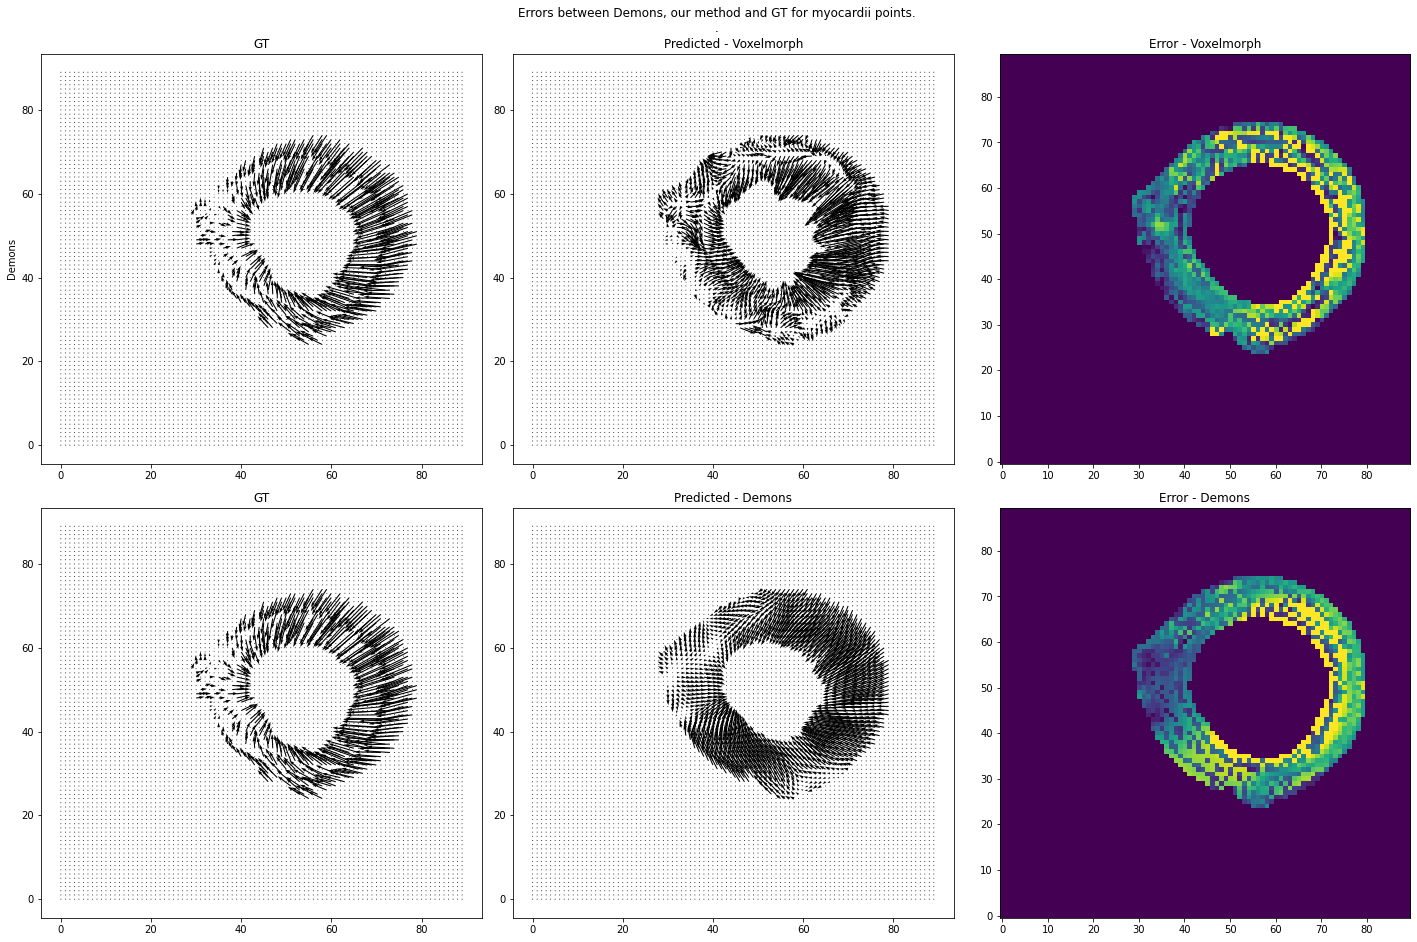

In [41]:
from helpers import get_segmentation

non_dilated = get_segmentation(folder, "v4", shape, (0, 0, 0), slice=5)
sl_dilated = get_segmentation(folder, "v4", shape, (2, 2, 0), slice=5)
dilated = get_segmentation(folder, "v4", shape, (6, 6, 0), slice=5)
sl_dilated_ = sl_dilated[..., np.newaxis]

Phi_mskd = Phi_usz * sl_dilated_
Phi_dem_mskd = Phi_demons_usz * sl_dilated_
Phix_gt = Phix_gt * sl_dilated
Phiy_gt = Phiy_gt * sl_dilated
Phix_mskd, Phiy_mskd = Phi_mskd[..., 0], Phi_mskd[..., 1]
Phix_dem_mskd, Phiy_dem_mskd = Phi_dem_mskd[..., 1], Phi_dem_mskd[..., 0]
Phi_dem_mskd_ = np.zeros_like(Phi_dem_mskd)
Phi_dem_mskd_[..., 0] = Phi_dem_mskd[..., 1]
Phi_dem_mskd_[..., 1] = Phi_dem_mskd[..., 0]

error_msk = np.linalg.norm((Phi_mskd - Phi_gt[..., 5, :-1]) * sl_dilated_, axis=2)
error_dem_msk = np.linalg.norm(
    (Phi_dem_mskd_ - Phi_gt[..., 5, :-1]) * sl_dilated_, axis=2
)

fig, axs = plt.subplots(2, 3, figsize=(20, 13.3))
fig.suptitle("Errors between Demons, our method and GT for myocardii points.\n.")
axs[0, 0].set_ylabel("Voxelmorph")
axs[0, 0].quiver(Phix_gt, Phiy_gt, angles="xy", scale_units="xy", scale=1)
axs[0, 1].quiver(Phix_mskd, Phiy_mskd, angles="xy", scale_units="xy", scale=1)
axs[0, 2].imshow(error_msk, origin="lower", vmin=0, vmax=5)
axs[1, 0].set_ylabel("Demons")
axs[1, 0].quiver(Phix_gt, Phiy_gt, angles="xy", scale_units="xy", scale=1)
axs[1, 1].quiver(Phix_dem_mskd, Phiy_dem_mskd, angles="xy", scale_units="xy", scale=1)
axs[1, 2].imshow(error_dem_msk, origin="lower", vmin=0, vmax=5)
for row, method in enumerate(["Voxelmorph", "Demons"]):
    for col, image in enumerate(["GT", "Predicted", "Error"]):
        axs[row, col].set_title(f"{image} - {method}" if col!=0 else f"{image}") 
plt.tight_layout()
plt.show()


Last but not least, we can check what happens on the points that correspond to the material points of the ground truth:

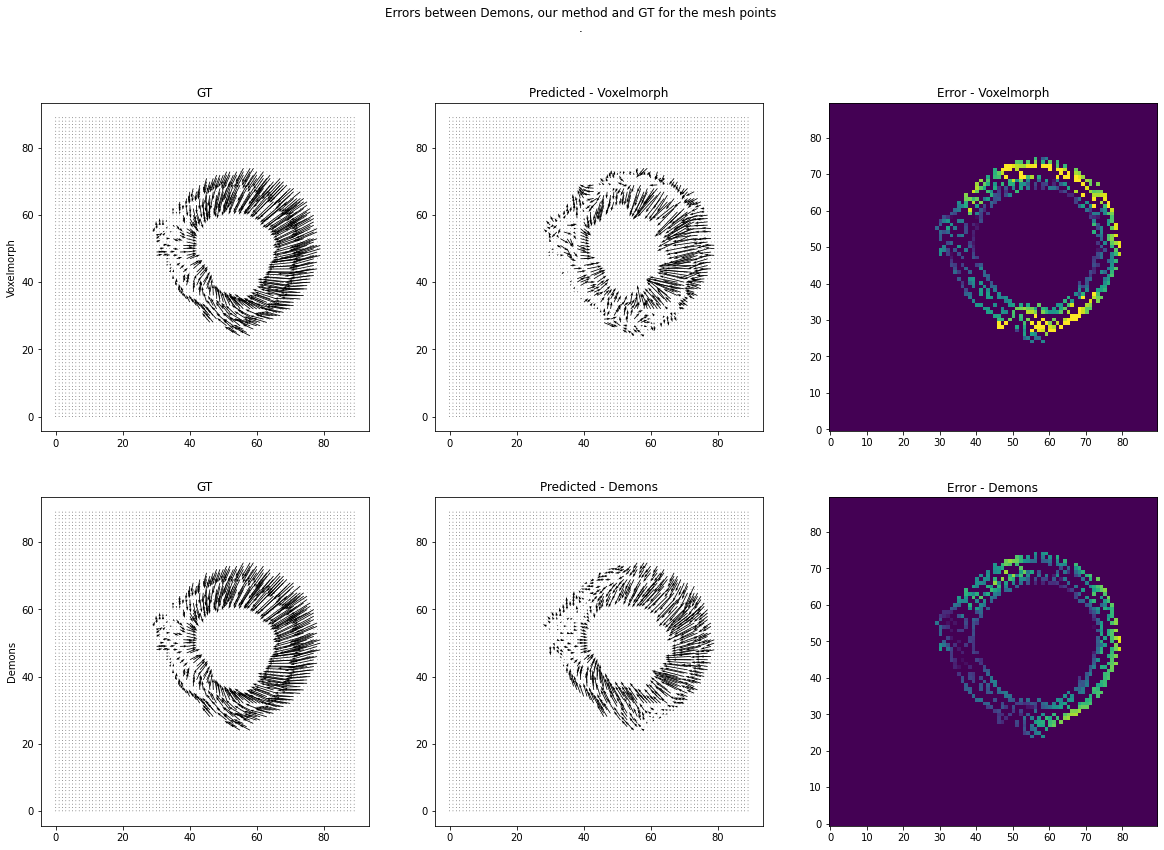

In [43]:

other_mask = np.linalg.norm(Phi_gt[..., 5, :], axis=2) > 0
other_mask_ = other_mask[..., np.newaxis]


Phi_mskd = Phi_usz * other_mask_ * sl_dilated_
Phi_dem_mskd = Phi_demons_usz * other_mask_ * sl_dilated_
Phix_gt = Phix_gt * other_mask * sl_dilated
Phiy_gt = Phiy_gt * other_mask * sl_dilated
Phix_mskd, Phiy_mskd = Phi_mskd[..., 0], Phi_mskd[..., 1]
Phix_dem_mskd, Phiy_dem_mskd = Phi_dem_mskd[..., 1], Phi_dem_mskd[..., 0]

error_msk = np.linalg.norm(
    (Phi_mskd - Phi_gt[..., 5, :-1])*other_mask_ * sl_dilated_, axis=2
)
error_dem_msk = np.linalg.norm(
    (Phi_dem_mskd_ - Phi_gt[..., 5, :-1])*other_mask_ * sl_dilated_, axis=2
)

fig, axs = plt.subplots(2, 3, figsize=(20, 13.3))
fig.suptitle("Errors between Demons, our method and GT for the mesh points\n.")
axs[0, 0].set_ylabel("Voxelmorph")
axs[0, 0].quiver(Phix_gt, Phiy_gt,  angles='xy', scale_units='xy',scale=1)
axs[0, 1].quiver(Phix_mskd, Phiy_mskd,  angles='xy', scale_units='xy',scale=1)
axs[0, 2].imshow(error_msk, origin="lower", vmin=0, vmax=5)
axs[1, 0].set_ylabel("Demons")
axs[1, 0].quiver(Phix_gt, Phiy_gt,  angles='xy', scale_units='xy',scale=1)
axs[1, 1].quiver(Phix_dem_mskd, Phiy_dem_mskd,  angles='xy', scale_units='xy',scale=1)
axs[1, 2].imshow(error_dem_msk, origin="lower", vmin=0, vmax=5)
for row, method in enumerate(["Voxelmorph", "Demons"]):
    for col, image in enumerate(["GT", "Predicted", "Error"]):
        axs[row, col].set_title(f"{image} - {method}" if col!=0 else f"{image}") 
plt.show()

It seems that we have certain pixels where the error is smaller in our methodology than in Demons. Nonetheless, we have an extremely noisy displacement field that may not be adequate to estimate strain. Now, let's take the histogram of said error points:

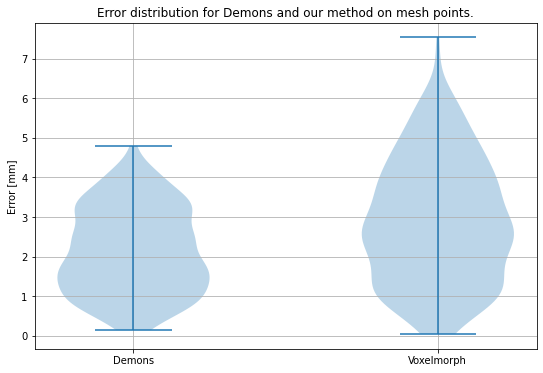

In [46]:
error_dem_msk_list = []
error_msk_list = []

for column in error_msk:
    for pixel in column:
        if pixel>0:
            error_msk_list.append(pixel)


for column in error_dem_msk:
    for pixel in column:
        if pixel>0:
            error_dem_msk_list.append(pixel)
plt.figure(figsize=(9,6))
plt.title("Error distribution for Demons and our method on mesh points.")
plt.grid()
plt.violinplot([error_dem_msk_list, error_msk_list])
plt.xticks([1,2], ["Demons", "Voxelmorph"])
plt.ylabel("Error [mm]")
plt.show()


## Conclusions 💡

Takeaways:
- Although the transformed image of Voxelmorph methodology is excellent (almost a pixel-wise representation of the final image), the displacement field is excesively noisy.
- A possible hypothesis is: would tracking features (i.e. tracking borders) help us get a more-correct displacement field?

Our next step (see EDA-004) is repeating this experiment using Feature Tracking. 